In [1]:
%matplotlib inline

In [2]:
import os
import pathlib
import sys

In [3]:
base_path = pathlib.Path(os.getcwd())
base_path = str(base_path.parent)
sys.path = [base_path] + sys.path

In [4]:
import glob
import random as python_random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [5]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG

In [6]:
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1.0, color_codes=True)

In [7]:
os.makedirs("./img/", exist_ok=True)
os.makedirs("./score/", exist_ok=True)

In [8]:
def set_experimental_environment(seed=6902):
    K.clear_session()

    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.
    np.random.seed(seed)

    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    python_random.seed(seed)

    # The below set_seed() will make random number generation
    # in the TensorFlow backend have a well-defined initial state.
    # For further details, see:
    # https://www.tensorflow.org/api_docs/python/tf/random/set_seed
    tf.random.set_seed(seed)

In [9]:
from pynvml import *

try:
    nvmlInit()
    print("Driver Version:", nvmlSystemGetDriverVersion())
    deviceCount = nvmlDeviceGetCount()
    for i in range(deviceCount):
        handle = nvmlDeviceGetHandleByIndex(i)
        print("Device", i, ":", nvmlDeviceGetName(handle))
    nvmlShutdown()
except NVMLError as error:
    print(error)

Driver Version: b'419.17'
Device 0 : b'GeForce GTX 1070 Ti'


In [10]:
from cpuinfo import get_cpu_info

for key, value in get_cpu_info().items():
    print("{0}: {1}".format(key, value))

python_version: 3.6.10.final.0 (64 bit)
cpuinfo_version: [7, 0, 0]
cpuinfo_version_string: 7.0.0
arch: X86_64
bits: 64
count: 12
arch_string_raw: AMD64
vendor_id_raw: GenuineIntel
brand_raw: Intel(R) Core(TM) i7-8700 CPU @ 3.20GHz
hz_advertised_friendly: 3.2000 GHz
hz_actual_friendly: 3.1920 GHz
hz_advertised: [3200000000, 0]
hz_actual: [3192000000, 0]
l2_cache_size: 1572864
stepping: 10
model: 158
family: 6
l3_cache_size: 12582912
flags: ['3dnow', '3dnowprefetch', 'abm', 'acpi', 'adx', 'aes', 'apic', 'avx', 'avx2', 'bmi1', 'bmi2', 'clflush', 'clflushopt', 'cmov', 'cx16', 'cx8', 'de', 'dtes64', 'dts', 'erms', 'est', 'f16c', 'fma', 'fpu', 'fxsr', 'hle', 'ht', 'hypervisor', 'ia64', 'invpcid', 'lahf_lm', 'mca', 'mce', 'mmx', 'movbe', 'mpx', 'msr', 'mtrr', 'osxsave', 'pae', 'pat', 'pbe', 'pcid', 'pclmulqdq', 'pdcm', 'pge', 'pni', 'popcnt', 'pse', 'pse36', 'rdrnd', 'rdseed', 'rtm', 'sep', 'serial', 'smap', 'smep', 'ss', 'sse', 'sse2', 'sse4_1', 'sse4_2', 'ssse3', 'tm', 'tm2', 'tsc', 'vme', 

In [11]:
import psutil 

mem = psutil.virtual_memory() 
print("memory: {0:.2f}GB".format(mem.total / 1024**3))

memory: 15.92GB


In [12]:
BAYES_MODELS = [
    "MNIST-CNN",
]

LAST_ACTIVATIONS = [
    "sigmoid",
    "softmax",
]

PREDICTION_MODES = [
    "Normal-mode",
    "Linear-mode",
    "Independent-mode",
    "Upper-mode",
    "MC-mode",
]

DATASETS = [
    "MNIST",
    "Fashion",
    "Kuzushiji",
    "Kannada",
    "EMNIST-MNIST",
]

In [13]:
class Args(object):
    max_seed = 30
    train_domain = DATASETS[1]
    bayes_model= BAYES_MODELS[0]
    num_mc = 2000
    optimizer = "Adam"
    train_batch_size = 128
    test_batch_size = 2048
    max_epochs = 100
    patience = 10
    rhos = [0.0, 1.0e-5, 5.0e-5, 1.0e-4, 5.0e-4, 1.0e-3, 5.0e-3, 1.0e-2, 5.0e-2, 1.0e-1]

In [14]:
def kuzushiji_load_data():
    ds = tfds.load(
        "kmnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    return (x_train, y_train), (x_test, y_test)


def kannada_load_data():
    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_train.npz",
    )
    y_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_train.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_train.npz",
    )
    x_train = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "y_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/y_kannada_MNIST_test.npz",
    )
    y_test = np.load(path)["arr_0"]

    path = tf.keras.utils.get_file(
        "X_kannada_MNIST_test.npz",
        "https://github.com/vinayprabhu/Kannada_MNIST/raw/master/data/output_tensors/MNIST_format/X_kannada_MNIST_test.npz",
    )
    x_test = np.load(path)["arr_0"]

    return (x_train, y_train), (x_test, y_test)


def emnist_mnist_load_data():
    ds = tfds.load(
        "emnist/mnist", split=["train", "test"], shuffle_files=False, batch_size=-1
    )
    ds = tfds.as_numpy(ds)
    y_train = ds[0]["label"].astype("uint8")
    x_train = ds[0]["image"].reshape((-1, 28, 28)).astype("uint8")
    y_test = ds[1]["label"].astype("uint8")
    x_test = ds[1]["image"].reshape((-1, 28, 28)).astype("uint8")

    x_train = np.array([x.T for x in x_train])
    x_test = np.array([x.T for x in x_test])

    return (x_train, y_train), (x_test, y_test)


def load_dataset(dataset, val_size=1.0 / 6.0):
    if dataset == DATASETS[0]:
        load_data = keras.datasets.mnist.load_data
    elif dataset == DATASETS[1]:
        load_data = keras.datasets.fashion_mnist.load_data
    elif dataset == DATASETS[2]:
        load_data = kuzushiji_load_data
    elif dataset == DATASETS[3]:
        load_data = kannada_load_data
    elif dataset == DATASETS[4]:
        load_data = emnist_mnist_load_data
    else:
        raise ValueError("Error")

    # input image dimensions
    num_classes = 10

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = load_data()

    # Scale images to the [0, 1] range
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0
    # Make sure images have shape (28, 28, 1)
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)

    if val_size > 0.0:
        x_train, x_val, y_train, y_val = train_test_split(
            x_train, y_train, test_size=val_size, stratify=y_train
        )
    else:
        x_val, y_val = x_train, y_train

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_val = keras.utils.to_categorical(y_val, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_val, y_val), (x_test, y_test), num_classes

In [15]:
def calc_softmax_entropy(prob):
    entropy = np.sum(-prob * np.log(np.maximum(prob, 1.0e-7)), axis=-1)
    return entropy


def calc_sigmoid_entropy(prob):
    entropy = np.sum(
        -prob * np.log(np.maximum(prob, 1.0e-7))
        - (1.0 - prob) * np.log(np.maximum(1.0 - prob, 1.0e-7)),
        axis=-1,
    )
    return entropy

In [16]:
def create_last_bayes_model(input_shape, output_shape, last_activation):
    # https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
    inputs = keras.Input(input_shape)
    conv1 = layers.Conv2D(32, kernel_size=(3, 3), activation="relu")(inputs)
    conv2 = layers.Conv2D(64, (3, 3), activation="relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    drop1 = layers.Dropout(0.25)(pool1)
    flat1 = layers.Flatten()(drop1)
    dense1 = layers.Dense(128, activation="relu")(flat1)
    drop2 = layers.Dropout(0.5)(dense1)
    dense2 = layers.Dense(output_shape, activation=last_activation)(drop2)
    model = keras.Model(inputs=inputs, outputs=dense2)

    return model


def create_bayes_model(bayes_model_name, input_shape, output_shape, last_activation):
    if bayes_model_name == BAYES_MODELS[0]:
        model = create_last_bayes_model(input_shape, output_shape, last_activation)
    else:
        raise ValueError()

    return model

In [17]:
args = Args()

In [18]:
from vpbnn import vlayers
from vpbnn.models import nn2vpbnn

for last_activation in LAST_ACTIVATIONS:
    for seed in range(args.max_seed):
        set_experimental_environment(seed)
        
        (x_train, y_train), (x_val, y_val), (_, _), num_classes = load_dataset(
            args.train_domain
        )        
        
        input_shape = x_train.shape[1:]
        model = create_bayes_model(
            args.bayes_model, input_shape, num_classes, last_activation
        )

        if last_activation == "softmax":
            loss_func = "categorical_crossentropy"
            calc_entropy = calc_softmax_entropy
        elif last_activation == "sigmoid":
            loss_func = "binary_crossentropy"
            calc_entropy = calc_sigmoid_entropy
        else:
            raise ValueError()

        es = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            min_delta=0,
            patience=args.patience,
            verbose=1,
            mode="auto",
            restore_best_weights=True,
        )

        model.compile(
            loss=loss_func, optimizer=args.optimizer, metrics=["accuracy"],
        )

        model.fit(
            x_train,
            y_train,
            batch_size=args.train_batch_size,
            epochs=args.max_epochs,
            verbose=2,
            validation_data=(x_val, y_val),
            callbacks=[es],
        )
        
        if last_activation == "sigmoid":
            best_rho = None
            best_ll = -np.inf
            for rho in args.rhos:
                vmodel = nn2vpbnn(model, variance_mode=3, rho=rho)
                y_prob, y_var = vmodel.predict(x_val, batch_size=args.test_batch_size)
                ll = -0.5 * np.square(y_val - y_prob) / np.maximum(y_var, 1.0e-7) - 0.5 * np.log(2.0 * np.pi) - 0.5 * np.log(np.maximum(y_var, 1.0e-7))
                ll = ll.mean()
                print("rho: {0}, ll: {1}".format(rho, ll))                
                if ll > best_ll:
                    best_rho = rho
                    best_ll = ll
            print("best_rho: {0}, best_ll: {1}".format(best_rho, best_ll))
            vmodel = nn2vpbnn(model, rho=best_rho)
        else:
            vmodel = nn2vpbnn(model)
        
        score_dfs = []
        for prediction_type in PREDICTION_MODES:
            for test_domain in DATASETS:
                (_, _), (_, _), (x_test, y_test), _ = load_dataset(test_domain)
                if prediction_type == PREDICTION_MODES[0]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 0
                    vmodel.compile(loss=loss_func)

                    y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[1]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 1
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[2]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 2
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                elif prediction_type == PREDICTION_MODES[3]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 3
                    vmodel.compile(loss=loss_func)

                    y_prob, y_var = vmodel.predict(x_test, batch_size=args.test_batch_size)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(np.sqrt(y_var), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)            
                elif prediction_type == PREDICTION_MODES[4]:
                    for layer in vmodel.layers:
                        if isinstance(layer, vlayers.VarianceLayer):
                            layer.variance_mode = 4
                    vmodel.compile(loss=loss_func)

                    y_probs = []
                    for _ in range(args.num_mc):
                        for layer in model.layers:
                            if isinstance(layer, vlayers.VarianceDropout):
                                layer.update_dropout_mask()
                        y_prob, _ = vmodel.predict(x_test, batch_size=args.test_batch_size)
                        y_probs.append(y_prob)
                    y_probs = np.array(y_probs)
                    y_prob = y_probs.mean(axis=0)
                    y_pred = np.argmax(y_prob, axis=-1)
                    y_entropy = calc_entropy(y_prob)
                    y_mean_std = np.mean(y_probs.std(axis=0, ddof=1), axis=-1)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(prediction_type, "entropy"),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_entropy,
                        }
                    )
                    score_dfs.append(score_df)
                    score_df = pd.DataFrame(
                        {
                            "prediction_type": "{0}_{1}".format(
                                prediction_type, "mean-std"
                            ),
                            "train_domain": args.train_domain,
                            "test_domain": test_domain,
                            "y_index": np.arange(x_test.shape[0]),
                            "y_test": np.argmax(y_test, axis=-1),
                            "y_pred": y_pred,
                            "y_prob": np.max(y_prob, axis=-1),
                            "y_uncertainty": y_mean_std,
                        }
                    )
                    score_dfs.append(score_df)
                else:
                    raise ValueError()
        score_df = pd.concat(score_dfs, ignore_index=True)
        score_df["seed"] = seed
        score_df["bayes_model"] = args.bayes_model
        score_df["last_activation"] = last_activation    
        score_df.to_csv("score/ood_{0}_{1:03}.csv".format(last_activation, seed), index=False)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 6s - loss: 0.1204 - accuracy: 0.9545 - val_loss: 0.0635 - val_accuracy: 0.9751
Epoch 2/100
50000/50000 - 3s - loss: 0.0718 - accuracy: 0.9728 - val_loss: 0.0535 - val_accuracy: 0.9791
Epoch 3/100
50000/50000 - 3s - loss: 0.0630 - accuracy: 0.9760 - val_loss: 0.0507 - val_accuracy: 0.9800
Epoch 4/100
50000/50000 - 3s - loss: 0.0571 - accuracy: 0.9780 - val_loss: 0.0459 - val_accuracy: 0.9822
Epoch 5/100
50000/50000 - 3s - loss: 0.0534 - accuracy: 0.9794 - val_loss: 0.0445 - val_accuracy: 0.9825
Epoch 6/100
50000/50000 - 3s - loss: 0.0487 - accuracy: 0.9811 - val_loss: 0.0437 - val_accuracy: 0.9823
Epoch 7/100
50000/50000 - 3s - loss: 0.0463 - accuracy: 0.9819 - val_loss: 0.0410 - val_accuracy: 0.9837
Epoch 8/100
50000/50000 - 3s - loss: 0.0438 - accuracy: 0.9830 - val_loss: 0.0411 - val_accuracy: 0.9845
Epoch 9/100
50000/50000 - 3s - loss: 0.0409 - accuracy: 0.9839 - val_loss: 0.0399 - val_accuracy: 0.9844
Epoch

Epoch 00023: early stopping
rho: 0.0, ll: 1.295642375946045
rho: 1e-05, ll: 1.2956585884094238
rho: 5e-05, ll: 1.2957026958465576
rho: 0.0001, ll: 1.2957103252410889
rho: 0.0005, ll: 1.294197678565979
rho: 0.001, ll: 1.2893959283828735
rho: 0.005, ll: 1.2076843976974487
rho: 0.01, ll: 1.0808016061782837
rho: 0.05, ll: 0.35830214619636536
rho: 0.1, ll: -0.0022738748230040073
best_rho: 0.0001, best_ll: 1.2957103252410889
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1188 - accuracy: 0.9547 - val_loss: 0.0645 - val_accuracy: 0.9754
Epoch 2/100
50000/50000 - 3s - loss: 0.0718 - accuracy: 0.9725 - val_loss: 0.0552 - val_accuracy: 0.9786
Epoch 3/100
50000/50000 - 3s - loss: 0.0615 - accuracy: 0.9762 - val_loss: 0.0491 - val_accuracy: 0.9812
Epoch 4/100
50000/50000 - 3s - loss: 0.0561 - accuracy: 0.9785 - val_loss: 0.0474 - val_accuracy: 0.9815
Epoch 5/100
50000/50000 - 3s - loss: 0.0517 - accuracy: 0.9800 - val_loss: 0.0437 - val_accuracy: 0.9836
Ep

Epoch 22/100
50000/50000 - 3s - loss: 0.0248 - accuracy: 0.9900 - val_loss: 0.0442 - val_accuracy: 0.9858
Epoch 23/100
50000/50000 - 3s - loss: 0.0246 - accuracy: 0.9901 - val_loss: 0.0430 - val_accuracy: 0.9856
Epoch 24/100
50000/50000 - 3s - loss: 0.0239 - accuracy: 0.9905 - val_loss: 0.0433 - val_accuracy: 0.9857
Epoch 25/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0232 - accuracy: 0.9907 - val_loss: 0.0435 - val_accuracy: 0.9853
Epoch 00025: early stopping
rho: 0.0, ll: 1.2849841117858887
rho: 1e-05, ll: 1.2849997282028198
rho: 5e-05, ll: 1.2850441932678223
rho: 0.0001, ll: 1.2850590944290161
rho: 0.0005, ll: 1.2837880849838257
rho: 0.001, ll: 1.279563307762146
rho: 0.005, ll: 1.2041558027267456
rho: 0.01, ll: 1.0837310552597046
rho: 0.05, ll: 0.37217915058135986
rho: 0.1, ll: 0.007833544164896011
best_rho: 0.0001, best_ll: 1.2850590944290161
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1160 - ac

Epoch 12/100
50000/50000 - 3s - loss: 0.0371 - accuracy: 0.9853 - val_loss: 0.0379 - val_accuracy: 0.9857
Epoch 13/100
50000/50000 - 3s - loss: 0.0351 - accuracy: 0.9860 - val_loss: 0.0371 - val_accuracy: 0.9860
Epoch 14/100
50000/50000 - 3s - loss: 0.0344 - accuracy: 0.9867 - val_loss: 0.0374 - val_accuracy: 0.9861
Epoch 15/100
50000/50000 - 3s - loss: 0.0331 - accuracy: 0.9870 - val_loss: 0.0379 - val_accuracy: 0.9862
Epoch 16/100
50000/50000 - 3s - loss: 0.0320 - accuracy: 0.9873 - val_loss: 0.0375 - val_accuracy: 0.9867
Epoch 17/100
50000/50000 - 3s - loss: 0.0311 - accuracy: 0.9875 - val_loss: 0.0377 - val_accuracy: 0.9862
Epoch 18/100
50000/50000 - 3s - loss: 0.0298 - accuracy: 0.9882 - val_loss: 0.0385 - val_accuracy: 0.9858
Epoch 19/100
50000/50000 - 3s - loss: 0.0289 - accuracy: 0.9885 - val_loss: 0.0379 - val_accuracy: 0.9863
Epoch 20/100
50000/50000 - 3s - loss: 0.0277 - accuracy: 0.9888 - val_loss: 0.0389 - val_accuracy: 0.9868
Epoch 21/100
50000/50000 - 3s - loss: 0.0267 -

50000/50000 - 4s - loss: 0.1270 - accuracy: 0.9517 - val_loss: 0.0677 - val_accuracy: 0.9735
Epoch 2/100
50000/50000 - 3s - loss: 0.0751 - accuracy: 0.9711 - val_loss: 0.0560 - val_accuracy: 0.9782
Epoch 3/100
50000/50000 - 3s - loss: 0.0650 - accuracy: 0.9751 - val_loss: 0.0507 - val_accuracy: 0.9806
Epoch 4/100
50000/50000 - 3s - loss: 0.0590 - accuracy: 0.9772 - val_loss: 0.0484 - val_accuracy: 0.9818
Epoch 5/100
50000/50000 - 3s - loss: 0.0544 - accuracy: 0.9790 - val_loss: 0.0475 - val_accuracy: 0.9819
Epoch 6/100
50000/50000 - 3s - loss: 0.0508 - accuracy: 0.9802 - val_loss: 0.0457 - val_accuracy: 0.9829
Epoch 7/100
50000/50000 - 3s - loss: 0.0478 - accuracy: 0.9813 - val_loss: 0.0423 - val_accuracy: 0.9838
Epoch 8/100
50000/50000 - 3s - loss: 0.0456 - accuracy: 0.9821 - val_loss: 0.0413 - val_accuracy: 0.9844
Epoch 9/100
50000/50000 - 3s - loss: 0.0431 - accuracy: 0.9831 - val_loss: 0.0406 - val_accuracy: 0.9848
Epoch 10/100
50000/50000 - 3s - loss: 0.0414 - accuracy: 0.9837 - v

Epoch 21/100
50000/50000 - 3s - loss: 0.0246 - accuracy: 0.9902 - val_loss: 0.0403 - val_accuracy: 0.9866
Epoch 22/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0240 - accuracy: 0.9904 - val_loss: 0.0422 - val_accuracy: 0.9866
Epoch 00022: early stopping
rho: 0.0, ll: 1.2830501794815063
rho: 1e-05, ll: 1.283182144165039
rho: 5e-05, ll: 1.283679485321045
rho: 0.0001, ll: 1.2842366695404053
rho: 0.0005, ll: 1.2866010665893555
rho: 0.001, ll: 1.2858372926712036
rho: 0.005, ll: 1.224582314491272
rho: 0.01, ll: 1.1109167337417603
rho: 0.05, ll: 0.3930380046367645
rho: 0.1, ll: 0.016349367797374725
best_rho: 0.0005, best_ll: 1.2866010665893555
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1302 - accuracy: 0.9495 - val_loss: 0.0639 - val_accuracy: 0.9749
Epoch 2/100
50000/50000 - 3s - loss: 0.0771 - accuracy: 0.9705 - val_loss: 0.0566 - val_accuracy: 0.9779
Epoch 3/100
50000/50000 - 3s - loss: 0.0677 - accurac

Epoch 6/100
50000/50000 - 3s - loss: 0.0505 - accuracy: 0.9806 - val_loss: 0.0447 - val_accuracy: 0.9824
Epoch 7/100
50000/50000 - 3s - loss: 0.0483 - accuracy: 0.9813 - val_loss: 0.0424 - val_accuracy: 0.9830
Epoch 8/100
50000/50000 - 3s - loss: 0.0455 - accuracy: 0.9823 - val_loss: 0.0418 - val_accuracy: 0.9833
Epoch 9/100
50000/50000 - 3s - loss: 0.0428 - accuracy: 0.9831 - val_loss: 0.0410 - val_accuracy: 0.9838
Epoch 10/100
50000/50000 - 3s - loss: 0.0410 - accuracy: 0.9839 - val_loss: 0.0403 - val_accuracy: 0.9840
Epoch 11/100
50000/50000 - 3s - loss: 0.0392 - accuracy: 0.9846 - val_loss: 0.0412 - val_accuracy: 0.9842
Epoch 12/100
50000/50000 - 3s - loss: 0.0379 - accuracy: 0.9850 - val_loss: 0.0393 - val_accuracy: 0.9848
Epoch 13/100
50000/50000 - 3s - loss: 0.0359 - accuracy: 0.9859 - val_loss: 0.0400 - val_accuracy: 0.9844
Epoch 14/100
50000/50000 - 3s - loss: 0.0350 - accuracy: 0.9861 - val_loss: 0.0393 - val_accuracy: 0.9852
Epoch 15/100
50000/50000 - 3s - loss: 0.0335 - acc

Epoch 22/100
50000/50000 - 3s - loss: 0.0253 - accuracy: 0.9898 - val_loss: 0.0451 - val_accuracy: 0.9847
Epoch 23/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0249 - accuracy: 0.9899 - val_loss: 0.0452 - val_accuracy: 0.9849
Epoch 00023: early stopping
rho: 0.0, ll: 1.3222565650939941
rho: 1e-05, ll: 1.3222249746322632
rho: 5e-05, ll: 1.3220821619033813
rho: 0.0001, ll: 1.3218693733215332
rho: 0.0005, ll: 1.3190034627914429
rho: 0.001, ll: 1.3132330179214478
rho: 0.005, ll: 1.2319506406784058
rho: 0.01, ll: 1.1078965663909912
rho: 0.05, ll: 0.3836468756198883
rho: 0.1, ll: 0.012913638725876808
best_rho: 0.0, best_ll: 1.3222565650939941
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1223 - accuracy: 0.9533 - val_loss: 0.0666 - val_accuracy: 0.9740
Epoch 2/100
50000/50000 - 3s - loss: 0.0741 - accuracy: 0.9715 - val_loss: 0.0582 - val_accuracy: 0.9767
Epoch 3/100
50000/50000 - 3s - loss: 0.0652 - accurac

Epoch 10/100
50000/50000 - 3s - loss: 0.0380 - accuracy: 0.9852 - val_loss: 0.0400 - val_accuracy: 0.9842
Epoch 11/100
50000/50000 - 3s - loss: 0.0366 - accuracy: 0.9855 - val_loss: 0.0394 - val_accuracy: 0.9848
Epoch 12/100
50000/50000 - 3s - loss: 0.0346 - accuracy: 0.9865 - val_loss: 0.0383 - val_accuracy: 0.9851
Epoch 13/100
50000/50000 - 3s - loss: 0.0327 - accuracy: 0.9870 - val_loss: 0.0390 - val_accuracy: 0.9854
Epoch 14/100
50000/50000 - 3s - loss: 0.0318 - accuracy: 0.9875 - val_loss: 0.0388 - val_accuracy: 0.9857
Epoch 15/100
50000/50000 - 3s - loss: 0.0306 - accuracy: 0.9879 - val_loss: 0.0395 - val_accuracy: 0.9853
Epoch 16/100
50000/50000 - 3s - loss: 0.0292 - accuracy: 0.9882 - val_loss: 0.0405 - val_accuracy: 0.9858
Epoch 17/100
50000/50000 - 3s - loss: 0.0284 - accuracy: 0.9887 - val_loss: 0.0396 - val_accuracy: 0.9858
Epoch 18/100
50000/50000 - 3s - loss: 0.0273 - accuracy: 0.9892 - val_loss: 0.0388 - val_accuracy: 0.9857
Epoch 19/100
50000/50000 - 3s - loss: 0.0261 -

Epoch 00027: early stopping
rho: 0.0, ll: 1.3492050170898438
rho: 1e-05, ll: 1.3491398096084595
rho: 5e-05, ll: 1.3488610982894897
rho: 0.0001, ll: 1.3484739065170288
rho: 0.0005, ll: 1.3440715074539185
rho: 0.001, ll: 1.3361480236053467
rho: 0.005, ll: 1.2370405197143555
rho: 0.01, ll: 1.0956997871398926
rho: 0.05, ll: 0.3412929177284241
rho: 0.1, ll: -0.01609661430120468
best_rho: 0.0, best_ll: 1.3492050170898438
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1241 - accuracy: 0.9524 - val_loss: 0.0708 - val_accuracy: 0.9712
Epoch 2/100
50000/50000 - 3s - loss: 0.0745 - accuracy: 0.9714 - val_loss: 0.0582 - val_accuracy: 0.9767
Epoch 3/100
50000/50000 - 3s - loss: 0.0651 - accuracy: 0.9752 - val_loss: 0.0522 - val_accuracy: 0.9797
Epoch 4/100
50000/50000 - 3s - loss: 0.0593 - accuracy: 0.9771 - val_loss: 0.0491 - val_accuracy: 0.9803
Epoch 5/100
50000/50000 - 3s - loss: 0.0552 - accuracy: 0.9785 - val_loss: 0.0458 - val_accuracy: 0.9821
Epoch 

Epoch 16/100
50000/50000 - 3s - loss: 0.0309 - accuracy: 0.9876 - val_loss: 0.0409 - val_accuracy: 0.9851
Epoch 17/100
50000/50000 - 3s - loss: 0.0299 - accuracy: 0.9882 - val_loss: 0.0410 - val_accuracy: 0.9854
Epoch 18/100
50000/50000 - 3s - loss: 0.0288 - accuracy: 0.9884 - val_loss: 0.0412 - val_accuracy: 0.9859
Epoch 19/100
50000/50000 - 3s - loss: 0.0275 - accuracy: 0.9890 - val_loss: 0.0396 - val_accuracy: 0.9858
Epoch 20/100
50000/50000 - 3s - loss: 0.0265 - accuracy: 0.9894 - val_loss: 0.0418 - val_accuracy: 0.9859
Epoch 21/100
50000/50000 - 3s - loss: 0.0260 - accuracy: 0.9895 - val_loss: 0.0434 - val_accuracy: 0.9851
Epoch 22/100
50000/50000 - 3s - loss: 0.0255 - accuracy: 0.9899 - val_loss: 0.0424 - val_accuracy: 0.9858
Epoch 23/100
50000/50000 - 3s - loss: 0.0247 - accuracy: 0.9901 - val_loss: 0.0432 - val_accuracy: 0.9857
Epoch 24/100
50000/50000 - 3s - loss: 0.0239 - accuracy: 0.9903 - val_loss: 0.0427 - val_accuracy: 0.9861
Epoch 25/100
50000/50000 - 3s - loss: 0.0234 -

Epoch 33/100
50000/50000 - 3s - loss: 0.0247 - accuracy: 0.9899 - val_loss: 0.0430 - val_accuracy: 0.9865
Epoch 34/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0247 - accuracy: 0.9900 - val_loss: 0.0429 - val_accuracy: 0.9862
Epoch 00034: early stopping
rho: 0.0, ll: 1.1629719734191895
rho: 1e-05, ll: 1.1628974676132202
rho: 5e-05, ll: 1.1625765562057495
rho: 0.0001, ll: 1.1621243953704834
rho: 0.0005, ll: 1.1568537950515747
rho: 0.001, ll: 1.1474125385284424
rho: 0.005, ll: 1.0412272214889526
rho: 0.01, ll: 0.907244086265564
rho: 0.05, ll: 0.26197701692581177
rho: 0.1, ll: -0.047956641763448715
best_rho: 0.0, best_ll: 1.1629719734191895
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.1191 - accuracy: 0.9541 - val_loss: 0.0663 - val_accuracy: 0.9740
Epoch 2/100
50000/50000 - 3s - loss: 0.0727 - accuracy: 0.9720 - val_loss: 0.0562 - val_accuracy: 0.9782
Epoch 3/100
50000/50000 - 3s - loss: 0.0634 - accura

Epoch 21/100
50000/50000 - 3s - loss: 0.1019 - accuracy: 0.9612 - val_loss: 0.2366 - val_accuracy: 0.9321
Epoch 22/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0973 - accuracy: 0.9621 - val_loss: 0.2464 - val_accuracy: 0.9301
Epoch 00022: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5505 - accuracy: 0.8040 - val_loss: 0.3414 - val_accuracy: 0.8741
Epoch 2/100
50000/50000 - 3s - loss: 0.3611 - accuracy: 0.8719 - val_loss: 0.2794 - val_accuracy: 0.8967
Epoch 3/100
50000/50000 - 3s - loss: 0.3107 - accuracy: 0.8885 - val_loss: 0.2571 - val_accuracy: 0.9071
Epoch 4/100
50000/50000 - 3s - loss: 0.2783 - accuracy: 0.8988 - val_loss: 0.2400 - val_accuracy: 0.9091
Epoch 5/100
50000/50000 - 3s - loss: 0.2482 - accuracy: 0.9092 - val_loss: 0.2234 - val_accuracy: 0.9185
Epoch 6/100
50000/50000 - 3s - loss: 0.2302 - accuracy: 0.9158 - val_loss: 0.2289 - val_accuracy: 0.9194
Epoch 7/100
50000/50000 

Epoch 10/100
50000/50000 - 3s - loss: 0.1646 - accuracy: 0.9377 - val_loss: 0.2223 - val_accuracy: 0.9232
Epoch 11/100
50000/50000 - 3s - loss: 0.1514 - accuracy: 0.9426 - val_loss: 0.2214 - val_accuracy: 0.9244
Epoch 12/100
50000/50000 - 3s - loss: 0.1432 - accuracy: 0.9457 - val_loss: 0.2227 - val_accuracy: 0.9234
Epoch 13/100
50000/50000 - 3s - loss: 0.1333 - accuracy: 0.9496 - val_loss: 0.2278 - val_accuracy: 0.9246
Epoch 14/100
50000/50000 - 3s - loss: 0.1262 - accuracy: 0.9518 - val_loss: 0.2231 - val_accuracy: 0.9287
Epoch 15/100
50000/50000 - 3s - loss: 0.1171 - accuracy: 0.9549 - val_loss: 0.2229 - val_accuracy: 0.9279
Epoch 16/100
50000/50000 - 3s - loss: 0.1121 - accuracy: 0.9575 - val_loss: 0.2375 - val_accuracy: 0.9255
Epoch 17/100
50000/50000 - 3s - loss: 0.1063 - accuracy: 0.9604 - val_loss: 0.2383 - val_accuracy: 0.9299
Epoch 18/100
50000/50000 - 3s - loss: 0.1010 - accuracy: 0.9605 - val_loss: 0.2444 - val_accuracy: 0.9285
Epoch 19/100
Restoring model weights from the 

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5616 - accuracy: 0.8009 - val_loss: 0.3411 - val_accuracy: 0.8790
Epoch 2/100
50000/50000 - 3s - loss: 0.3612 - accuracy: 0.8720 - val_loss: 0.2845 - val_accuracy: 0.8950
Epoch 3/100
50000/50000 - 3s - loss: 0.3050 - accuracy: 0.8909 - val_loss: 0.2709 - val_accuracy: 0.8990
Epoch 4/100
50000/50000 - 3s - loss: 0.2756 - accuracy: 0.9003 - val_loss: 0.2453 - val_accuracy: 0.9103
Epoch 5/100
50000/50000 - 3s - loss: 0.2469 - accuracy: 0.9102 - val_loss: 0.2428 - val_accuracy: 0.9147
Epoch 6/100
50000/50000 - 3s - loss: 0.2279 - accuracy: 0.9161 - val_loss: 0.2288 - val_accuracy: 0.9166
Epoch 7/100
50000/50000 - 3s - loss: 0.2100 - accuracy: 0.9222 - val_loss: 0.2253 - val_accuracy: 0.9190
Epoch 8/100
50000/50000 - 3s - loss: 0.1962 - accuracy: 0.9260 - val_loss: 0.2242 - val_accuracy: 0.9207
Epoch 9/100
50000/50000 - 3s - loss: 0.1818 - accuracy: 0.9338 - val_loss: 0.2183 - val_accuracy: 0.9241
Epoch

Epoch 12/100
50000/50000 - 3s - loss: 0.1590 - accuracy: 0.9395 - val_loss: 0.2341 - val_accuracy: 0.9230
Epoch 13/100
50000/50000 - 3s - loss: 0.1544 - accuracy: 0.9420 - val_loss: 0.2213 - val_accuracy: 0.9267
Epoch 14/100
50000/50000 - 3s - loss: 0.1442 - accuracy: 0.9446 - val_loss: 0.2380 - val_accuracy: 0.9230
Epoch 15/100
50000/50000 - 3s - loss: 0.1373 - accuracy: 0.9487 - val_loss: 0.2353 - val_accuracy: 0.9243
Epoch 16/100
50000/50000 - 3s - loss: 0.1298 - accuracy: 0.9502 - val_loss: 0.2405 - val_accuracy: 0.9244
Epoch 17/100
50000/50000 - 3s - loss: 0.1229 - accuracy: 0.9536 - val_loss: 0.2593 - val_accuracy: 0.9249
Epoch 18/100
50000/50000 - 3s - loss: 0.1186 - accuracy: 0.9550 - val_loss: 0.2376 - val_accuracy: 0.9263
Epoch 19/100
50000/50000 - 3s - loss: 0.1096 - accuracy: 0.9583 - val_loss: 0.2456 - val_accuracy: 0.9264
Epoch 20/100
50000/50000 - 3s - loss: 0.1081 - accuracy: 0.9579 - val_loss: 0.2586 - val_accuracy: 0.9239
Epoch 21/100
50000/50000 - 3s - loss: 0.1017 -

Epoch 20/100
50000/50000 - 3s - loss: 0.0998 - accuracy: 0.9613 - val_loss: 0.2286 - val_accuracy: 0.9304
Epoch 21/100
50000/50000 - 3s - loss: 0.0968 - accuracy: 0.9633 - val_loss: 0.2577 - val_accuracy: 0.9291
Epoch 22/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0913 - accuracy: 0.9641 - val_loss: 0.2410 - val_accuracy: 0.9283
Epoch 00022: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 - 4s - loss: 0.5579 - accuracy: 0.8027 - val_loss: 0.3356 - val_accuracy: 0.8755
Epoch 2/100
50000/50000 - 3s - loss: 0.3625 - accuracy: 0.8717 - val_loss: 0.2903 - val_accuracy: 0.8929
Epoch 3/100
50000/50000 - 3s - loss: 0.3120 - accuracy: 0.8881 - val_loss: 0.2622 - val_accuracy: 0.9024
Epoch 4/100
50000/50000 - 3s - loss: 0.2799 - accuracy: 0.8994 - val_loss: 0.2508 - val_accuracy: 0.9047
Epoch 5/100
50000/50000 - 3s - loss: 0.2521 - accuracy: 0.9077 - val_loss: 0.2394 - val_accuracy: 0.9116
Epoch 6/100
50000/50000

Epoch 9/100
50000/50000 - 3s - loss: 0.1932 - accuracy: 0.9272 - val_loss: 0.2124 - val_accuracy: 0.9266
Epoch 10/100
50000/50000 - 3s - loss: 0.1797 - accuracy: 0.9321 - val_loss: 0.2098 - val_accuracy: 0.9289
Epoch 11/100
50000/50000 - 3s - loss: 0.1696 - accuracy: 0.9356 - val_loss: 0.2097 - val_accuracy: 0.9292
Epoch 12/100
50000/50000 - 3s - loss: 0.1607 - accuracy: 0.9388 - val_loss: 0.2042 - val_accuracy: 0.9325
Epoch 13/100
50000/50000 - 3s - loss: 0.1522 - accuracy: 0.9430 - val_loss: 0.2182 - val_accuracy: 0.9276
Epoch 14/100
50000/50000 - 3s - loss: 0.1452 - accuracy: 0.9449 - val_loss: 0.2190 - val_accuracy: 0.9302
Epoch 15/100
50000/50000 - 3s - loss: 0.1366 - accuracy: 0.9478 - val_loss: 0.2138 - val_accuracy: 0.9314
Epoch 16/100
50000/50000 - 3s - loss: 0.1298 - accuracy: 0.9504 - val_loss: 0.2116 - val_accuracy: 0.9315
Epoch 17/100
50000/50000 - 3s - loss: 0.1236 - accuracy: 0.9533 - val_loss: 0.2120 - val_accuracy: 0.9325
Epoch 18/100
50000/50000 - 3s - loss: 0.1187 - 

Epoch 16/100
50000/50000 - 3s - loss: 0.1246 - accuracy: 0.9527 - val_loss: 0.2099 - val_accuracy: 0.9290
Epoch 17/100
50000/50000 - 3s - loss: 0.1178 - accuracy: 0.9553 - val_loss: 0.2152 - val_accuracy: 0.9318
Epoch 18/100
50000/50000 - 3s - loss: 0.1126 - accuracy: 0.9572 - val_loss: 0.2171 - val_accuracy: 0.9318
Epoch 19/100
50000/50000 - 3s - loss: 0.1064 - accuracy: 0.9584 - val_loss: 0.2140 - val_accuracy: 0.9304
Epoch 20/100
50000/50000 - 3s - loss: 0.1039 - accuracy: 0.9607 - val_loss: 0.2112 - val_accuracy: 0.9324
Epoch 21/100
50000/50000 - 3s - loss: 0.1005 - accuracy: 0.9614 - val_loss: 0.2221 - val_accuracy: 0.9325
Epoch 22/100
50000/50000 - 3s - loss: 0.0948 - accuracy: 0.9638 - val_loss: 0.2174 - val_accuracy: 0.9327
Epoch 23/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0872 - accuracy: 0.9666 - val_loss: 0.2366 - val_accuracy: 0.9332
Epoch 00023: early stopping
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/

Epoch 8/100
50000/50000 - 3s - loss: 0.2051 - accuracy: 0.9250 - val_loss: 0.2127 - val_accuracy: 0.9247
Epoch 9/100
50000/50000 - 3s - loss: 0.1910 - accuracy: 0.9298 - val_loss: 0.2093 - val_accuracy: 0.9248
Epoch 10/100
50000/50000 - 3s - loss: 0.1799 - accuracy: 0.9334 - val_loss: 0.2166 - val_accuracy: 0.9250
Epoch 11/100
50000/50000 - 3s - loss: 0.1692 - accuracy: 0.9371 - val_loss: 0.2072 - val_accuracy: 0.9266
Epoch 12/100
50000/50000 - 3s - loss: 0.1540 - accuracy: 0.9425 - val_loss: 0.2151 - val_accuracy: 0.9246
Epoch 13/100
50000/50000 - 3s - loss: 0.1470 - accuracy: 0.9448 - val_loss: 0.2123 - val_accuracy: 0.9265
Epoch 14/100
50000/50000 - 3s - loss: 0.1405 - accuracy: 0.9474 - val_loss: 0.2217 - val_accuracy: 0.9274
Epoch 15/100
50000/50000 - 3s - loss: 0.1320 - accuracy: 0.9501 - val_loss: 0.2136 - val_accuracy: 0.9283
Epoch 16/100
50000/50000 - 3s - loss: 0.1241 - accuracy: 0.9532 - val_loss: 0.2305 - val_accuracy: 0.9270
Epoch 17/100
50000/50000 - 3s - loss: 0.1202 - a

Epoch 23/100
50000/50000 - 3s - loss: 0.1040 - accuracy: 0.9604 - val_loss: 0.2477 - val_accuracy: 0.9295
Epoch 24/100
50000/50000 - 3s - loss: 0.1025 - accuracy: 0.9593 - val_loss: 0.2413 - val_accuracy: 0.9333
Epoch 25/100
Restoring model weights from the end of the best epoch.
50000/50000 - 3s - loss: 0.0965 - accuracy: 0.9624 - val_loss: 0.2610 - val_accuracy: 0.9327
Epoch 00025: early stopping


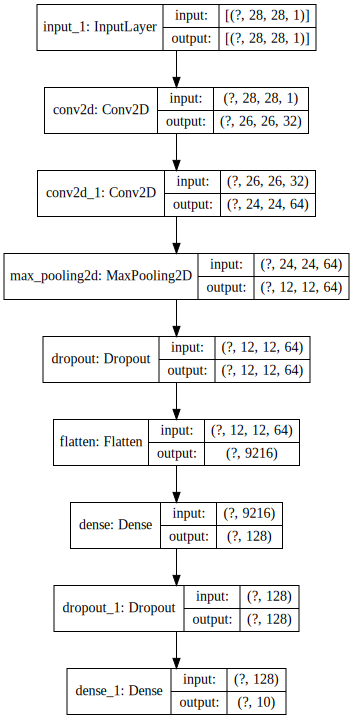

In [19]:
model_to_dot(model, show_shapes=True).write_pdf("img/ood_architecture-nn.pdf")
SVG(model_to_dot(model, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

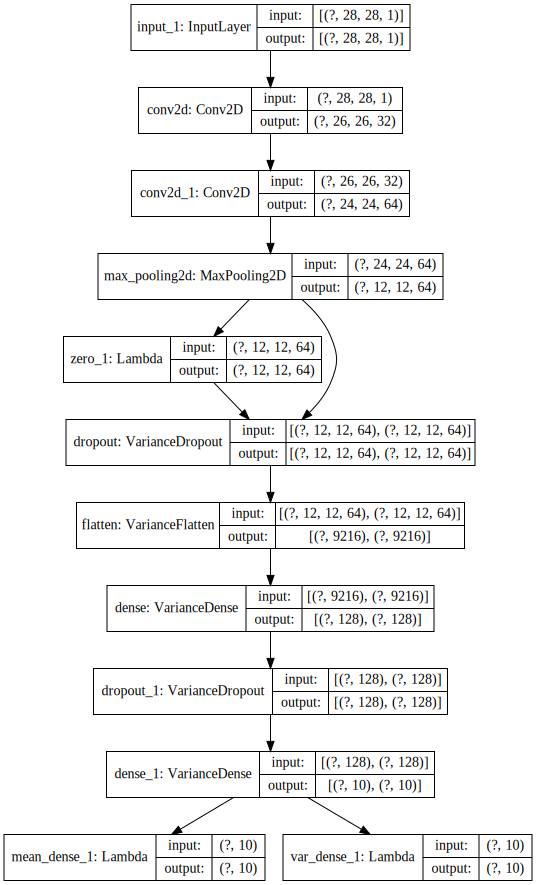

In [20]:
vmodel = nn2vpbnn(model)
model_to_dot(vmodel, show_shapes=True).write_pdf("img/ood_architecture-vpbnn.pdf")
SVG(model_to_dot(vmodel, show_shapes=True, dpi=72).create(prog='dot', format='svg'))

In [21]:
def calc_auc(df, train_domain, test_domain):
    auc_dfs = []
    for pred_type in df['prediction_type'].unique():
        for bayes_model in df['bayes_model'].unique():
            for activation in df['last_activation'].unique():            
                cond_df = df[df['prediction_type'] == pred_type]
                cond_df = cond_df[cond_df['bayes_model'] == bayes_model]
                cond_df = cond_df[cond_df['last_activation'] == activation]
                fpr, tpr, thresholds = metrics.roc_curve(cond_df['test_domain'], -cond_df['y_uncertainty'], pos_label=train_domain)
                roc_auc = metrics.auc(fpr, tpr)
                auc_df = pd.DataFrame({'train_domain': [train_domain], 'test_domain': [test_domain], 'prediction_type': [pred_type], 'bayes_model': [bayes_model], 'last_activation': [activation], 'auc': [roc_auc]})
                auc_dfs.append(auc_df)
        
    auc_df = pd.concat(auc_dfs, ignore_index=True)
    auc_df['seed'] = df['seed'].iloc[0]
        
    return auc_df

In [22]:
auc_dfs = []
for csv_filepath in sorted(glob.glob('score/*.csv')):
    score_df = pd.read_csv(csv_filepath)
    for train_domain in score_df['train_domain'].unique():
        other_domains = set(score_df['test_domain'].unique()) - set([train_domain])
        for other_domain in other_domains:
            cond = np.logical_and(score_df['train_domain'] == train_domain, np.logical_or(score_df['test_domain'] == train_domain, score_df['test_domain'] == other_domain))
            auc_df = calc_auc(score_df[cond], train_domain, other_domain)
            auc_dfs.append(auc_df)
    auc_df = pd.concat(auc_dfs, ignore_index=True)

In [23]:
pd.set_option("display.max_rows", None)

auc_mean_df = auc_df.groupby(['train_domain', 'test_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'auc': ['mean', 'std']})
auc_mean_df['auc_str'] = auc_mean_df.apply(lambda x: '{0:.3f}±{1:.3f}'.format(x['auc']['mean'], x['auc']['std']), axis=1)
auc_mean_df

auc  \
                                                                                     mean   
train_domain test_domain  prediction_type           bayes_model last_activation             
Fashion      EMNIST-MNIST Independent-mode_entropy  MNIST-CNN   sigmoid          0.855732   
                                                                softmax          0.899389   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.945595   
                                                                softmax          0.923978   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.754934   
                                                                softmax          0.791116   
                          Linear-mode_mean-std      MNIST-CNN   sigmoid          0.833288   
                                                                softmax          0.777429   
                          MC-mode_entropy           MNIST-CNN   sigmoid          0.846125   
                                                                softmax          0.892932   
                          MC-mode_mean-std          MNIST-CNN   sigmoid          0.937348   
                                                                softmax          0.941211   
                          Normal-mode_entropy       MNIST-CNN   sigmoid          0.754934   
                                                                softmax          0.791116   
                          Upper-mode_entropy        MNIST-CNN   sigmoid          0.856002   
                                                                softmax          0.742327   
                          Upper-mode_mean-std       MNIST-CNN   sigmoid          0.945612   
                                                                softmax          0.704681   
             Kannada      Independent-mode_entropy  MNIST-CNN   sigmoid          0.795410   
                                                                softmax          0.871186   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.915711   
                                                                softmax          0.904965   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.672482   
                                                                softmax          0.725301   
                          Linear-mode_mean-std      MNIST-CNN   sigmoid          0.766196   
                                                                softmax          0.737872   
                          MC-mode_entropy           MNIST-CNN   sigmoid          0.784925   
                                                                softmax          0.866803   
                          MC-mode_mean-std          MNIST-CNN   sigmoid          0.909194   
                                                                softmax          0.931495   
                          Normal-mode_entropy       MNIST-CNN   sigmoid          0.672482   
                                                                softmax          0.725301   
                          Upper-mode_entropy        MNIST-CNN   sigmoid          0.795749   
                                                                softmax          0.759617   
                          Upper-mode_mean-std       MNIST-CNN   sigmoid          0.915834   
                                                                softmax          0.766791   
             Kuzushiji    Independent-mode_entropy  MNIST-CNN   sigmoid          0.892334   
                                                                softmax          0.922824   
                          Independent-mode_mean-std MNIST-CNN   sigmoid          0.980926   
                                                                softmax          0.948911   
                          Linear-mode_entropy       MNIST-CNN   sigmoid          0.7657

In [24]:
accuracy_dfs = []
for csv_filepath in sorted(glob.glob('score/*.csv')):
    df = pd.read_csv(csv_filepath)
    df = df[df['train_domain'] == df['test_domain']]
    df['correct'] = df['y_test'] == df['y_pred']
    accuracy_df = df[['train_domain', 'prediction_type', 'bayes_model', 'last_activation', 'correct']].groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).mean().reset_index()
    accuracy_df = accuracy_df.rename(columns={'correct': 'accuracy'})
    accuracy_df['seed'] = df['seed'].iloc[0]
    accuracy_dfs.append(accuracy_df)
accuracy_df = pd.concat(accuracy_dfs, ignore_index=True)

In [25]:
accuracy_mean_df = accuracy_df.groupby(['train_domain', 'prediction_type', 'bayes_model', 'last_activation']).agg({'accuracy': ['mean', 'std']})
accuracy_mean_df['accuracy_str'] = accuracy_mean_df.apply(lambda x: '{0:.3f}±{1:.3f}'.format(x['accuracy']['mean'], x['accuracy']['std']), axis=1)
accuracy_mean_df

accuracy  \
                                                                        mean   
train_domain prediction_type           bayes_model last_activation             
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.923047   
                                                   softmax          0.923003   
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.923047   
                                                   softmax          0.923003   
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.923080   
                                                   softmax          0.922923   
             Linear-mode_mean-std      MNIST-CNN   sigmoid          0.923080   
                                                   softmax          0.922923   
             MC-mode_entropy           MNIST-CNN   sigmoid          0.923020   
                                                   softmax          0.922943   
             MC-mode_mean-std          MNIST-CNN   sigmoid          0.923020   
                                                   softmax          0.922943   
             Normal-mode_entropy       MNIST-CNN   sigmoid          0.923080   
                                                   softmax          0.922923   
             Upper-mode_entropy        MNIST-CNN   sigmoid          0.923010   
                                                   softmax          0.663260   
             Upper-mode_mean-std       MNIST-CNN   sigmoid          0.923010   
                                                   softmax          0.663260   

                                                                              \
                                                                         std   
train_domain prediction_type           bayes_model last_activation             
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.002346   
                                                   softmax          0.002630   
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.002346   
                                                   softmax          0.002630   
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.002315   
                                                   softmax          0.002527   
             Linear-mode_mean-std      MNIST-CNN   sigmoid          0.002315   
                                                   softmax          0.002527   
             MC-mode_entropy           MNIST-CNN   sigmoid          0.002347   
                                                   softmax          0.002649   
             MC-mode_mean-std          MNIST-CNN   sigmoid          0.002347   
                                                   softmax          0.002649   
             Normal-mode_entropy       MNIST-CNN   sigmoid          0.002315   
                                                   softmax          0.002527   
             Upper-mode_entropy        MNIST-CNN   sigmoid          0.002355   
                                                   softmax          0.083609   
             Upper-mode_mean-std       MNIST-CNN   sigmoid          0.002355   
                                                   softmax          0.083609   

                                                                   accuracy_str  
                                                                                 
train_domain prediction_type           bayes_model last_activation               
Fashion      Independent-mode_entropy  MNIST-CNN   sigmoid          0.923±0.002  
                                                   softmax          0.923±0.003  
             Independent-mode_mean-std MNIST-CNN   sigmoid          0.923±0.002  
                                                   softmax          0.923±0.003  
             Linear-mode_entropy       MNIST-CNN   sigmoid          0.923±0.002  
                                                  